In [1]:
%pylab inline
#%matplotlib qt
from __future__ import division # use so 1/2 = 0.5, etc.
import sk_dsp_comm.sigsys as ss
import sk_dsp_comm.pyaudio_helper as pah
import scipy.signal as signal
import time
import sys
import imp # for module development and reload()
from IPython.display import Audio, display
from IPython.display import Image, SVG

Populating the interactive namespace from numpy and matplotlib


In [2]:
pylab.rcParams['savefig.dpi'] = 100 # default 72
#pylab.rcParams['figure.figsize'] = (6.0, 4.0) # default (6,4)
#%config InlineBackend.figure_formats=['png'] # default for inline viewing
%config InlineBackend.figure_formats=['svg'] # SVG inline viewing
#%config InlineBackend.figure_formats=['pdf'] # render pdf figs for LaTeX
#Image('filename.png',width='80%')

In [4]:
def FT_approx(x,t,Nfft):
    '''
    Approximate the Fourier transform of a finite duration
    signal using scipy.signal.freqz()
    
    Inputs
    ------
       x = input signal array
       t = time array used to create x(t)
    Nfft = the number of frequency domain points used to 
           approximate X(f) on the interval [fs/2,fs/2], where
           fs = 1/Dt. Dt being the time spacing in array t
    
    Return
    ------
    f = frequency axis array in Hz
    X = the Fourier transform approximation (complex)
    
    Mark Wickert, January 2015
    '''
    fs = 1/(t[1] - t[0])
    t0 = (t[-1]+t[0])/2 # time delay at center
    N0 = len(t)/2 # FFT center in samples
    f = arange(-1/2,1/2,1/Nfft)
    w, X = signal.freqz(x,1,2*pi*f)
    X /= fs # account for dt = 1/fs in integral
    X *= exp(-1j*2*pi*f*fs*t0)# time interval correction
    X *= exp(1j*2*pi*f*N0)# FFT time interval is [0,Nfft-1]
    F = f*fs
    return F, X

# Signals 
Using the signal primitives `ss.rect(t,tau)` and `ss.tri(t,tau)` synthesize the following signal and also plot the corresponding frequency spectra.

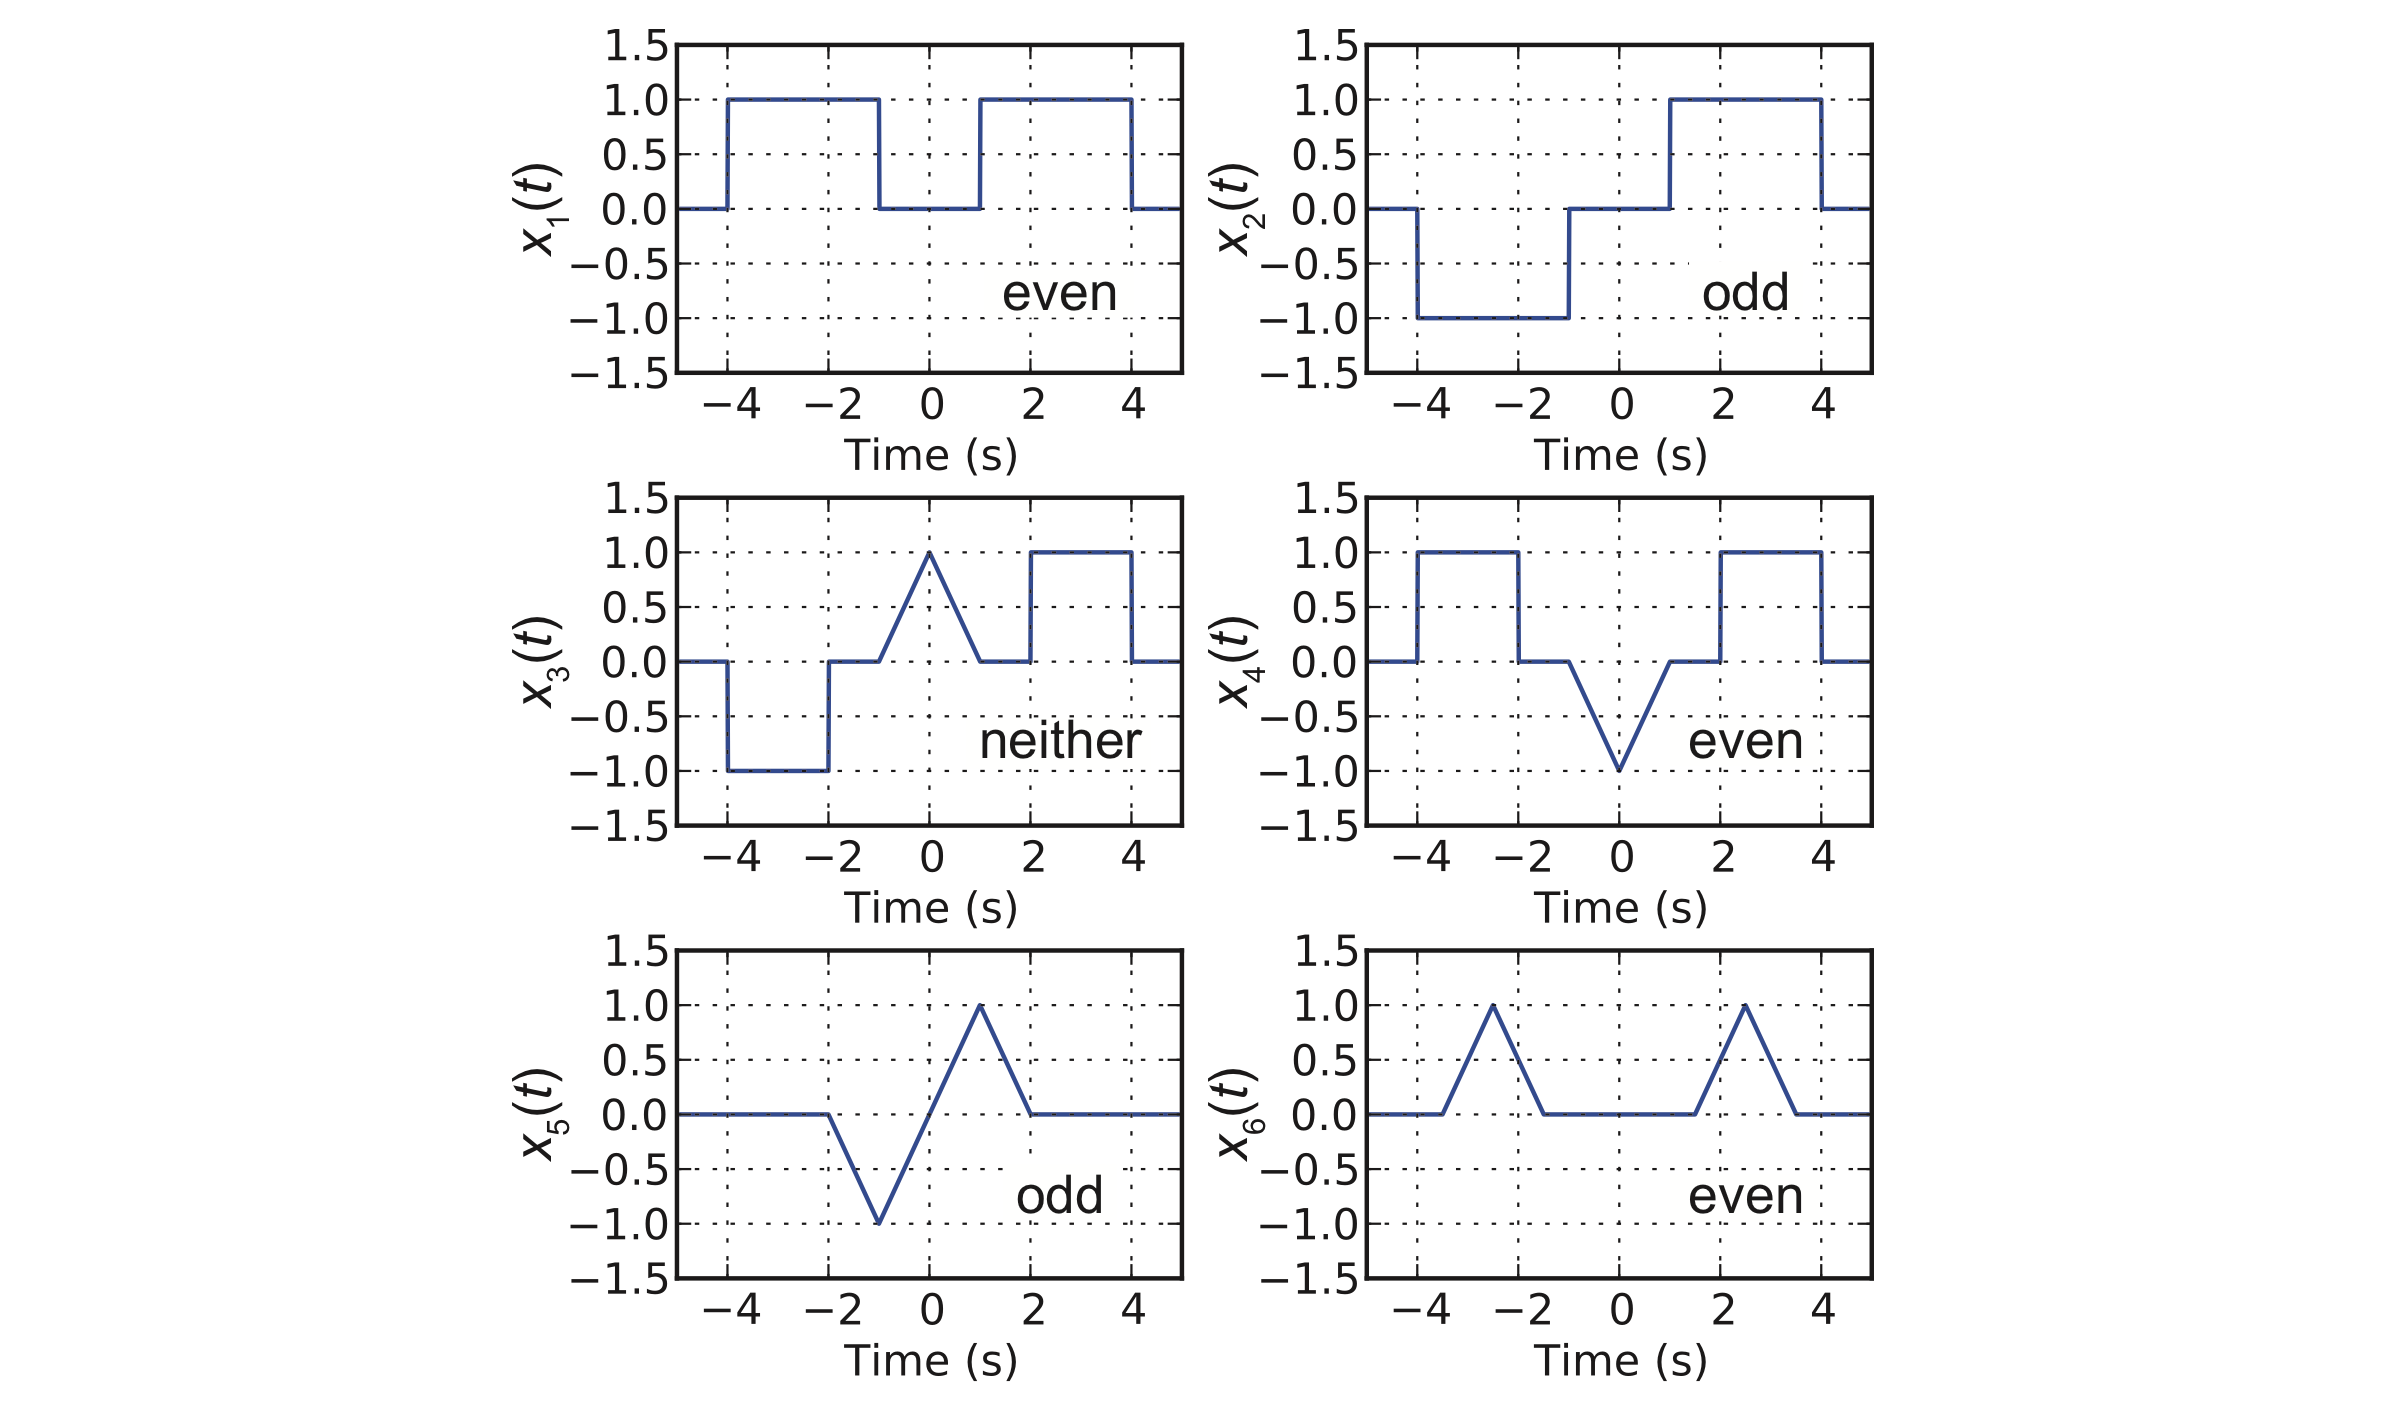

In [26]:
Image('images/Pulse_Signal_Modeling.png',width='100%')

* In working the examples below it worth recalling how re-mapping the argument of a function can be used to shift a function right or left

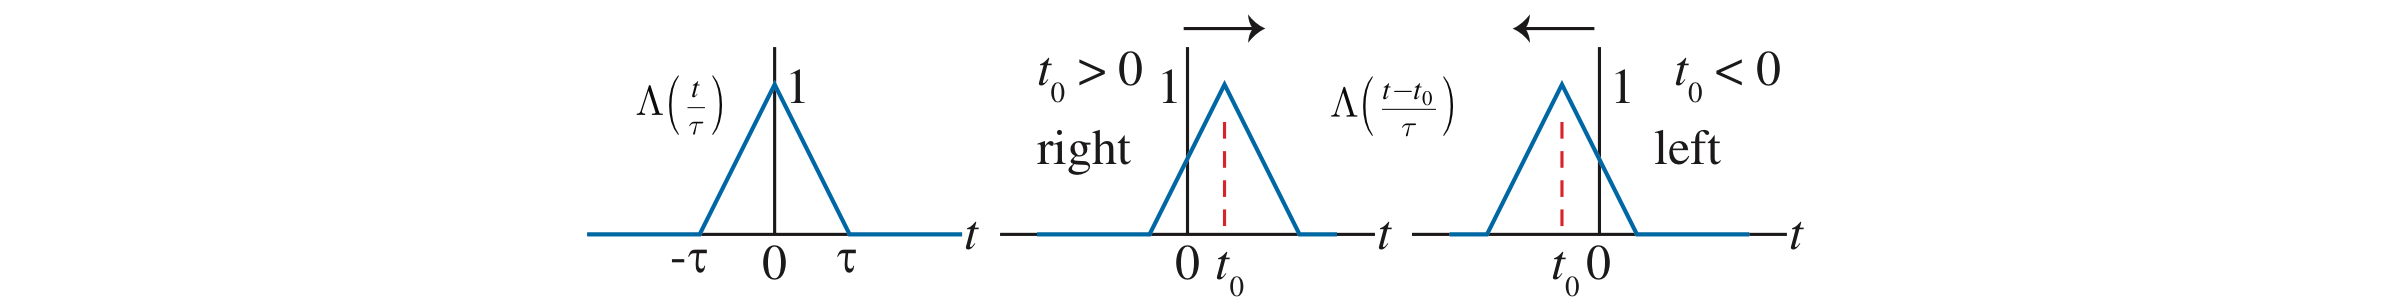

In [38]:
Image('images/Shifting_Functions.png',width='100%')

### Example: $x_5(t)$

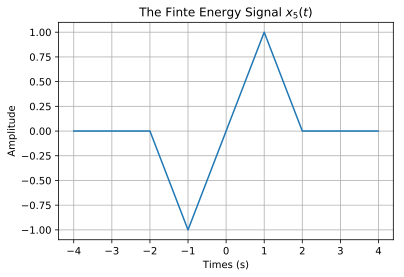

In [28]:
t = arange(-4,4,.01)
x5 = ss.tri(t-1,1) - ss.tri(t+1,1)
plot(t,x5)
ylabel(r'Amplitude')
xlabel(r'Times (s)')
title(r'The Finte Energy Signal $x_5(t)$')
grid();

The spectrum (Fourier transform)
$$
    X_5(f) = \int_{-\infty}^\infty x(t) e^{-j2\pi ft}\, dt 
$$
is numerically computed using `FT_approx()`.

In [32]:
F, X5 = FT_approx(x5,t,4096)

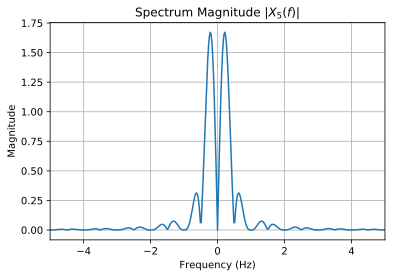

In [34]:
plot(F, abs(X5))
xlim([-5,5])
title(r'Spectrum Magnitude $|X_5(f)|$')
ylabel(r'Magnitude')
xlabel(r'Frequency (Hz)')
grid();

### Example: The Bi-Phase Pulse
This pulse is used in Manchester encoding of a bit stream.
$$
    p(t) = \Pi\left(\frac{t-T/4}{T/2}\right) - \Pi\left(\frac{t-3T/4}{T/2}\right)
$$
When each bit in a bit stream is mapped to the time axis using this pulse shape

1. There is a transition for every bit making sychronization easier
2. The spectrum does not contain and zero frequency components
3. Unfortunately the spectrum is wide than the simple rectangle $\pm 1 \times \Pi\big(t/T\big)$ pulse shape

In [35]:
# Complete this example by plottont $p(t)$ for $T = 1$ and plotting the spectrum.
# Overlay the spectrum of $\Pi(t/T)$ for $T=1$

# Code here

**Complete a Few Other Examples from the Figure Above** (time permitting)

## Raised Cosine and Square-root Raised Cosine
The module `digitalcom` utilizes this pulse shape in many of its functions. More later in **Part3**

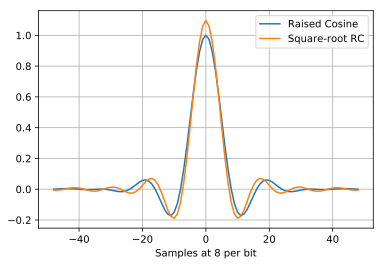

In [47]:
Ns = 8 # samples per bit period
p_RC = ss.rc_imp(Ns,0.35) # 0.35 is a popular excess bandwidth factor
p_SRC = ss.sqrt_rc_imp(Ns,0.35)
plot(n,p_RC)
plot(n,p_SRC)
legend((r'Raised Cosine',r'Square-root RC'),loc='best')
xlabel(r'Samples at 8 per bit')
grid()

## Aliasing
In `sigsys` the function `f_prin = prin_alias(f,fs)` finds the *principal alias* of a sinusoidal signal relative to the sampling rate $f_s$: 

In [9]:
# Some examples
(ss.prin_alias(25,100),ss.prin_alias(300,200),ss.prin_alias(18000,44100))

(25.0, 100.0, 18000.0)

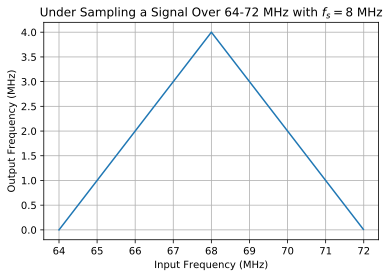

In [20]:
f = arange(64,72,.01)
f_prin = ss.prin_alias(f,8) # Sampling frequency is 8 MHz
plot(f,f_prin)
title(r'Under Sampling a Signal Over 64-72 MHz with $f_s = 8$ MHz')
ylabel(r'Output Frequency (MHz)')
xlabel(r'Input Frequency (MHz)')
grid();

# Systems

## Filter Design